In [21]:
import os
import time
import numpy as np
from collections import namedtuple
import importlib

import torch
import torch.nn as nn
import torch.optim as optim


In [2]:
from torchdiffeq import odeint_adjoint as odeint

In [33]:
importlib.reload(ode_models)

<module 'ode_models' from '/alt/applic/user-maint/zq224/WS/torchdiffeq/examples/ode_models.py'>

In [3]:
Arg = namedtuple('Arg', ['method', 'data_size', 'batch_time', 'batch_size', 
                         'niters', 'test_freq', 'viz', 'gpu', 'adjoint'])
args = Arg('dopri5', 1000, 10, 20, 2000, 20, False, 0, True)

In [4]:
device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

# initial value (2, 1)
true_y0 = torch.tensor([[2.0, 1.0]])
t = torch.linspace(-2.5, 2.5, args.data_size)

eps = 0.01

class Lambda(nn.Module):

    def forward(self, t, y):
        x = y[:, 0]
        dx_dt = 1 / eps * (y[:, 1] - 1.0 / 3.0 * x**3 + x)
        dy_dt = -x
        return torch.cat((dx_dt.reshape(-1, 1), dy_dt.reshape(-1, 1)), axis=1)

# This numerical solution given the true DE.
with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method='dopri5')


def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(args.data_size - args.batch_time, dtype=np.int64), args.batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:args.batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(args.batch_time)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y


In [5]:
plot_dir = 'png0'

def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

if args.viz:
    makedirs(plot_dir)
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(12, 4), facecolor='white')
    ax_traj = fig.add_subplot(131, frameon=False)
    ax_phase = fig.add_subplot(132, frameon=False)
    ax_vecfield = fig.add_subplot(133, frameon=False)
    plt.show(block=False)

    
def visualize(true_y, pred_y, odefunc, itr):

    if args.viz:

        ax_traj.cla()
        ax_traj.set_title('Trajectories')
        ax_traj.set_xlabel('t')
        ax_traj.set_ylabel('x,y')
        ax_traj.plot(t.numpy(), true_y.numpy()[:, 0, 0], t.numpy(), true_y.numpy()[:, 0, 1], 'g-')
        ax_traj.plot(t.numpy(), pred_y.numpy()[:, 0, 0], '--', t.numpy(), pred_y.numpy()[:, 0, 1], 'b--')
        ax_traj.set_xlim(t.min(), t.max())
        ax_traj.set_ylim(-2, 2)
#         ax_traj.legend()

        ax_phase.cla()
        ax_phase.set_title('Phase Portrait')
        ax_phase.set_xlabel('x')
        ax_phase.set_ylabel('y')
        ax_phase.plot(true_y.numpy()[:, 0, 0], true_y.numpy()[:, 0, 1], 'g-')
        ax_phase.plot(pred_y.numpy()[:, 0, 0], pred_y.numpy()[:, 0, 1], 'b--')
        ax_phase.set_xlim(t.min(), t.max())
        ax_phase.set_ylim(-2, 2)

        ax_vecfield.cla()
        ax_vecfield.set_title('Learned Vector Field')
        ax_vecfield.set_xlabel('x')
        ax_vecfield.set_ylabel('y')

        y, x = np.mgrid[-2:2:21j, -2:2:21j]
        dydt = odefunc(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2))).cpu().detach().numpy()
        mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
        dydt = (dydt / mag)
        dydt = dydt.reshape(21, 21, 2)

        ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")
        ax_vecfield.set_xlim(t.min(), t.max())
        ax_vecfield.set_ylim(-2, 2)

        fig.tight_layout()
        plt.savefig('{}/{:03d}'.format(plot_dir, itr))
        plt.draw()
        plt.show()
        plt.pause(0.001)


In [6]:
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val


In [7]:
ii = 0

func = ode_models.ODEFuncLayeredResidual()
optimizer = optim.Adam(func.parameters(), lr=1e-3)
end = time.time()

time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)

for itr in range(1, args.niters + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0, batch_t)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    time_meter.update(time.time() - end)
    loss_meter.update(loss.item())

    if itr % args.test_freq == 0:
        with torch.no_grad():
            pred_y = odeint(func, true_y0, t)
            loss = torch.mean(torch.abs(pred_y - true_y))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            visualize(true_y, pred_y, func, ii)
            ii += 1

    end = time.time()


Iter 0020 | Total Loss 1.317811
Iter 0040 | Total Loss 1.217991


KeyboardInterrupt: 

In [8]:
# makedirs('models')
model_file = 'models/ODEFuncLayeredResidual.pth'
# torch.save(func.state_dict(), model_file)

In [36]:
func = ode_models.ODEFuncLayeredResidual()
func.load_state_dict(torch.load(model_file))
func.eval()


func_fast = ode_models.ODEFuncLayeredResidualFastOnly()
func_fast.load_state_dict(torch.load(model_file))
func_fast.eval()

func_slow = ode_models.ODEFuncLayeredResidualSlowOnly()
func_slow.load_state_dict(torch.load(model_file))
func_slow.eval()


ODEFuncLayeredResidualSlowOnly(
  (net_y): Sequential(
    (0): Linear(in_features=4, out_features=50, bias=True)
    (1): Tanh()
  )
  (lin_y): Linear(in_features=50, out_features=2, bias=True)
  (net_x1): Sequential(
    (0): Linear(in_features=4, out_features=50, bias=True)
    (1): Tanh()
  )
  (net_x2): Sequential(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): Tanh()
  )
  (lin_x): Linear(in_features=50, out_features=2, bias=True)
)

In [53]:
with torch.no_grad():
    print(func_slow(t, true_y0))
    print(func_fast(t, true_y0))
    print(func(t, true_y0))

tensor([[-0.0413, -0.9608]])
tensor([[ 3.6652, -1.0436]])
tensor([[ 3.6239, -2.0043]])


In [83]:
plot_func = func
with torch.no_grad():
    pred_y = odeint(plot_func, true_y0, t)


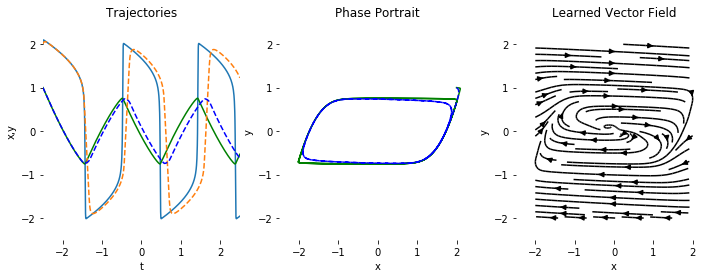

In [84]:
import matplotlib.pyplot as plt

with torch.no_grad():
    fig = plt.figure(figsize=(12, 4), facecolor='white')
    ax_traj = fig.add_subplot(131, frameon=False)
    ax_phase = fig.add_subplot(132, frameon=False)
    ax_vecfield = fig.add_subplot(133, frameon=False)


    ax_traj.cla()
    ax_traj.set_title('Trajectories')
    ax_traj.set_xlabel('t')
    ax_traj.set_ylabel('x,y')
    ax_traj.plot(t.numpy(), true_y.numpy()[:, 0, 0], t.numpy(), true_y.numpy()[:, 0, 1], 'g-')
    ax_traj.plot(t.numpy(), pred_y.numpy()[:, 0, 0], '--', t.numpy(), pred_y.numpy()[:, 0, 1], 'b--')
    ax_traj.set_xlim(t.min(), t.max())
    ax_traj.set_ylim(-2.5, 2.5)
#     ax_traj.legend()

    ax_phase.cla()
    ax_phase.set_title('Phase Portrait')
    ax_phase.set_xlabel('x')
    ax_phase.set_ylabel('y')
    ax_phase.plot(true_y.numpy()[:, 0, 0], true_y.numpy()[:, 0, 1], 'g-')
    ax_phase.plot(pred_y.numpy()[:, 0, 0], pred_y.numpy()[:, 0, 1], 'b--')
    ax_phase.set_xlim(t.min(), t.max())
    ax_phase.set_ylim(-2.5, 2.5)

    ax_vecfield.cla()
    ax_vecfield.set_title('Learned Vector Field')
    ax_vecfield.set_xlabel('x')
    ax_vecfield.set_ylabel('y')

    y, x = np.mgrid[-2:2:21j, -2:2:21j]
    dydt = plot_func(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2))).cpu().detach().numpy()
    mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
    dydt = (dydt / mag)
    dydt = dydt.reshape(21, 21, 2)

    ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")
    ax_vecfield.set_xlim(t.min(), t.max())
    ax_vecfield.set_ylim(-2.5, 2.5)

    # fig.tight_layout()
    # plt.savefig('{}/{:03d}'.format(plot_dir, itr))
    # plt.draw()
    # plt.show()
    # plt.pause(0.001)

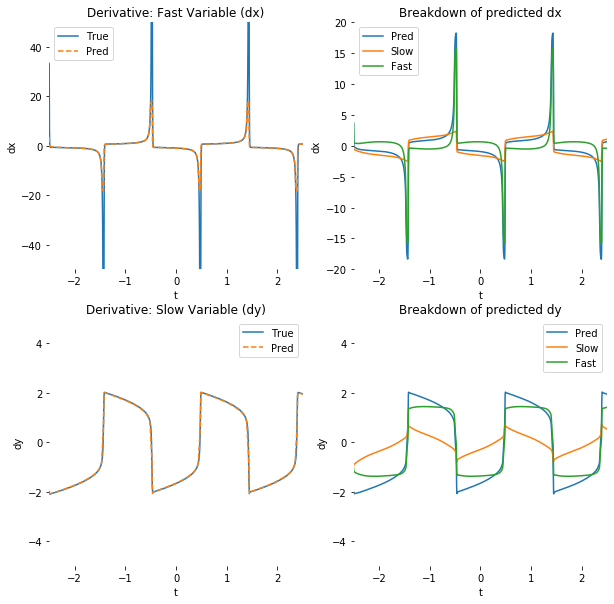

In [101]:
with torch.no_grad():
    grad_true = Lambda()(t, true_y.squeeze())
    
    grad_pred = func(t, true_y).squeeze()
    
    grad_slow = func_slow(t, true_y).squeeze()
    grad_fast = func_fast(t, true_y).squeeze()
    
    fig = plt.figure(figsize=(10, 10), facecolor='white')
    
    fig1 = fig.add_subplot(221, frameon=False)
    fig1.cla()
    fig1.set_title('Derivative: Fast Variable (dx)')
    fig1.set_xlabel('t')
    fig1.set_ylabel('dx')
    fig1.plot(t.numpy(), grad_true.numpy()[:, 0], label='True')
    fig1.plot(t.numpy(), grad_pred.numpy()[:, 0], '--', label='Pred')
    fig1.set_xlim(t.min(), t.max())
    fig1.set_ylim(-50., 50.)
    fig1.legend()
    
    fig2 = fig.add_subplot(222, frameon=False)
    fig2.cla()
    fig2.set_title('Breakdown of predicted dx')
    fig2.set_xlabel('t')
    fig2.set_ylabel('dx')
    fig2.plot(t.numpy(), grad_pred.numpy()[:, 0], label='Pred')
    fig2.plot(t.numpy(), grad_slow.numpy()[:, 0], label='Slow')
    fig2.plot(t.numpy(), grad_fast.numpy()[:, 0], label='Fast')
    fig2.set_xlim(t.min(), t.max())
    fig2.set_ylim(-20., 20.)
    fig2.legend()
    
    fig3 = fig.add_subplot(223, frameon=False)
    fig3.cla()
    fig3.set_title('Derivative: Slow Variable (dy)')
    fig3.set_xlabel('t')
    fig3.set_ylabel('dy')
    fig3.plot(t.numpy(), grad_true.numpy()[:, 1], label='True')
    fig3.plot(t.numpy(), grad_pred.numpy()[:, 1], '--', label='Pred')
    fig3.set_xlim(t.min(), t.max())
    fig3.set_ylim(-5., 5.)
    fig3.legend()
    
    fig4 = fig.add_subplot(224, frameon=False)
    fig4.cla()
    fig4.set_title('Breakdown of predicted dy')
    fig4.set_xlabel('t')
    fig4.set_ylabel('dy')
    fig4.plot(t.numpy(), grad_pred.numpy()[:, 1], label='Pred')
    fig4.plot(t.numpy(), grad_slow.numpy()[:, 1], label='Slow')
    fig4.plot(t.numpy(), grad_fast.numpy()[:, 1], label='Fast')
    fig4.set_xlim(t.min(), t.max())
    fig4.set_ylim(-5., 5.)
    fig4.legend()

In [73]:
grad_pred.squeeze().shape

torch.Size([1000, 2])